In [1]:
# --- Cell 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [2]:
# --- Cell 2: Load Excel & tidy columns ---
# File must be in the current working directory (or provide full path)
df = pd.read_excel("pqt.xlsx", sheet_name=0)

# Parse dates
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df[df["Date"].notna()].copy()

# Make column names easier to reference
df = df.rename(columns={
    "P (mm/day)": "P_mm_day",
    "Q (mm/day)": "Q_mm_day",
    "Tavg (C)"  : "T_C"
})

# Coerce numeric columns
for c in ["P_mm_day", "Q_mm_day", "T_C"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")


In [3]:
# --- Cell 3: Add Water Year (WY) and aggregate to annual (mm/year) ---
# Water Year: starts Oct 1; named for year it ends
df["WY"] = df["Date"].dt.year + (df["Date"].dt.month >= 10).astype(int)

# If there are duplicate dates, average them first (daily totals/means)
daily = (df
         .groupby(["Date", "WY"], as_index=False)
         .agg(P_mm_day=("P_mm_day","mean"),
              Q_mm_day=("Q_mm_day","mean"),
              T_C=("T_C","mean"))
        )

# Aggregate to water-year totals/means
wy_summary = (daily
              .groupby("WY", as_index=False)
              .agg(
                  P_mm_yr=("P_mm_day", "sum"),  # mm/day summed to mm/year
                  Q_mm_yr=("Q_mm_day", "sum"),  # mm/day summed to mm/year
                  n_days=("P_mm_day", "count")
              )
             )

# Long-term means (used for mean lines and normalization)
P_mean = wy_summary["P_mm_yr"].mean()
Q_mean = wy_summary["Q_mm_yr"].mean()

wy_summary.head()


,WY,P_mm_yr,Q_mm_yr,n_days
0,1980,782.63,188.923754,273
1,1981,520.31,26.574572,365
2,1982,869.25,139.852751,365
3,1983,1025.07,188.923754,365
4,1984,568.74,68.885273,366


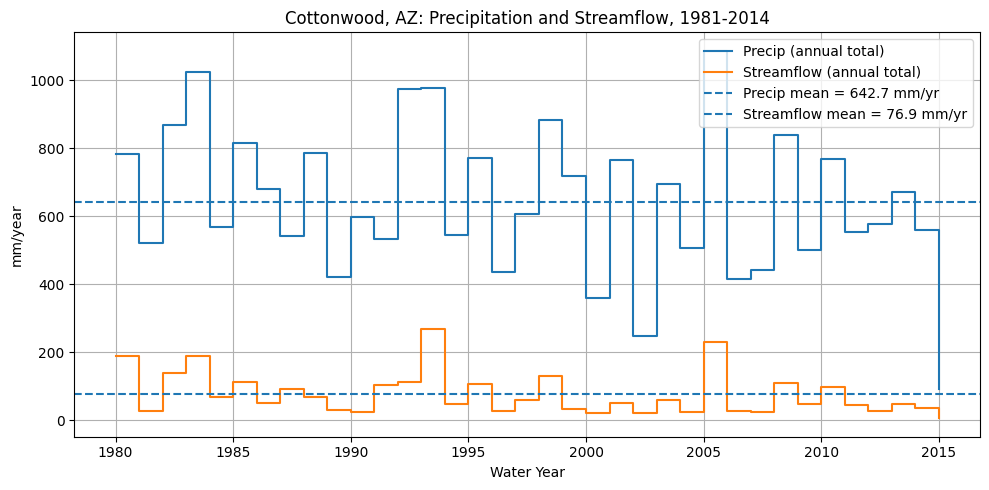

In [4]:
# --- Cell 4: Chart 1 — mm/year step plot with mean lines & legend ---
fig, ax = plt.subplots()

# Step plots (use 'post' so the step covers the WY to the right)
ax.step(wy_summary["WY"], wy_summary["P_mm_yr"], where="post", label="Precip (annual total)")
ax.step(wy_summary["WY"], wy_summary["Q_mm_yr"], where="post", label="Streamflow (annual total)")

# Mean reference lines
ax.axhline(P_mean, linestyle="--", label=f"Precip mean = {P_mean:.1f} mm/yr")
ax.axhline(Q_mean, linestyle="--", label=f"Streamflow mean = {Q_mean:.1f} mm/yr")

ax.set_xlabel("Water Year")
ax.set_ylabel("mm/year")
ax.set_title("Cottonwood, AZ: Precipitation and Streamflow, 1981-2014")
ax.legend()
plt.tight_layout()
plt.show()
